In [1]:
%cd ..

import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import copy

from PIL import Image
from torchvision import transforms
from utils import get_psnr, image_normalization
from alignment.alignment_utils import load_deep_jscc
from alignment.alignment_model import AlignedDeepJSCC
from alignment.alignment_validation import *

os.getcwd()
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

/home/lorenzo/repos/Deep-JSCC-PyTorch


In [2]:
# model1_fp = r'alignment/models/autoencoders/upscaled_42.pkl'
model1_fp = r'alignment/models/autoencoders/snr_0_seed_42.pkl'

# model2_fp = r'alignment/models/autoencoders/upscaled_43.pkl'
model2_fp = r'alignment/models/autoencoders/snr_0_seed_43.pkl'

aligner_fp = r'/home/lorenzo/repos/Deep-JSCC-PyTorch/alignment/models/plots/psnr_vs_pilots_5/aligner_mlp_10000.pkl'
aligner_fp = r'/home/lorenzo/repos/Deep-JSCC-PyTorch/alignment/models/plots/psnr_vs_pilots_5/aligner_linear_10000.pkl'

snr = 0
# image_path = r'demo/kodim23.png'
image_path = r'demo/0002.jpg'
times = 10
resolution = 96
upscale_factor = 4
c = 8

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

no_mismatch_model, unaligned_model, aligned_model = prepare_models(model1_fp, model2_fp, aligner_fp, snr, c)

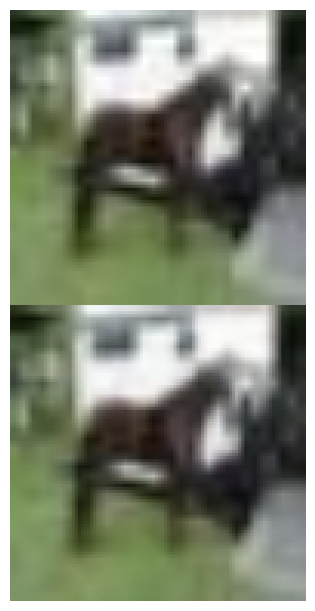

Average PSNR is 37.97 over 10 runs.


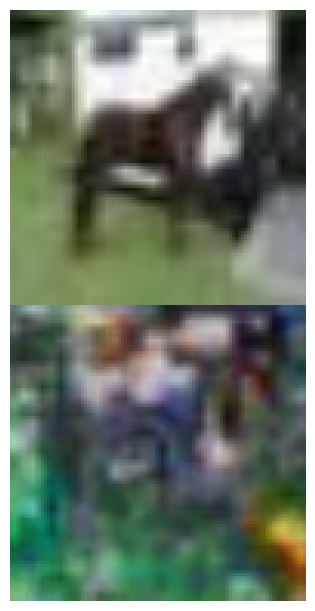

Average PSNR is 11.61 over 10 runs.


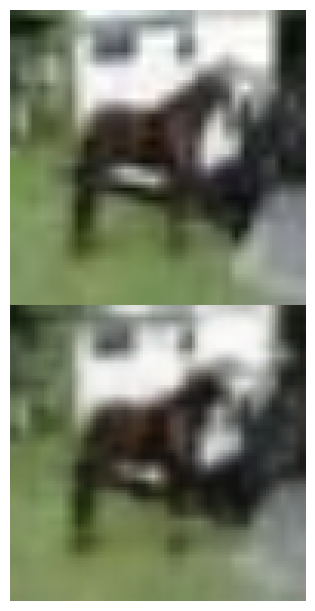

Average PSNR is 24.74 over 10 runs.


In [3]:
# without semantic mismatch
visualization_pipeline(no_mismatch_model, image_path, resolution, times, upscale_factor)

# with semantic mismatch, without aligning
visualization_pipeline(unaligned_model, image_path, resolution, times, upscale_factor)

# with semantic mismatch, with aligning
visualization_pipeline(aligned_model, image_path, resolution, times, upscale_factor)